# Node Representation Learning with attri2vec on Citeseer

This is the python implementation of the attri2vec algorithm outlined in paper ***[Attributed Network Embedding Via Subspace Discovery](https://arxiv.org/abs/1901.04095)*** D. Zhang, Y. Jie, X. Zhu and C. Zhang, arXiv:1901.04095, [cs.SI], 2019. The implementation uses the stellargraph libraries.


## attri2vec

attri2vec learns node representations by performing a linear/non-linear mapping on node content attributes. To make the learned node representations respect structural similarity, [`DeepWalk`](https://dl.acm.org/citation.cfm?id=2623732)/[`node2vec`](https://snap.stanford.edu/node2vec) learning mechanism is used to make nodes sharing similar random walk context nodes represented closely in the subspace, which is achieved by maximizing the occurrence probability of context nodes conditioned on the representation of the target nodes. The probability is modelled by Softmax and negative sampling is used to speed up its calculation. This makes attri2vec equivalent to predict whether a node occurs in the given target node's context in random walks with the representation of the target node, by minimizing the cross-entropy loss. 

In implementation, node embeddings are learnt by solving a simple classification task: given a large set of "positive" `(target, context)` node pairs generated from random walks performed on the graph (i.e., node pairs that co-occur within a certain context window in random walks), and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distribution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk performed on the graph. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attributes of nodes to node embeddings in a low-dimensional vector space, which preserves structural and feature similarities of the nodes. 

To train the attri2vec model, we first construct a training set of nodes, which is composed of an equal number of positive and negative `(target, context)` pairs from the graph. The positive `(target, context)` pairs are the node pairs co-occurring on random walks over the graph whereas the negative node pairs are the sampled randomly from the global node degree distribution of the graph. In attri2vec, each node is attached with two kinds of embeddings: 1) the inductive 'input embedding', i.e, the objective embedding, obtained by perform a linear/non-linear transformation on node content features, and 2) 'output embedding', i.e., the parameter vector used to predict its occurrence as a context node, obtained by looking up a parameter table. Given a `(target, context)` pair, attri2vec outputs a predictive value to indicate whether it is positive or negative, which is obtained by performing the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node, followed by a sigmoid activation. 

The entire model is trained end-to-end by minimizing the binary cross-entropy loss function with regards to predicted node pair labels and true node pair labels, using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' node pairs generated on demand and fed into the model.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from stellargraph import datasets
from IPython.display import display, HTML

## Dataset

In [2]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]


## Train attri2vec on Citeseer

Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk.

In [4]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5

Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [5]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

Set the batch size and the number of epochs. 

In [6]:
batch_size = 50
epochs = 4

Define an attri2vec training generator, which generates a batch of (feature of target node, index of context node, label of node pair) pairs per iteration.

In [7]:
generator = Attri2VecLinkGenerator(G, batch_size)
train_gen = generator.flow(unsupervised_samples)

Building the model: a 1-hidden-layer node representation ('input embedding') of the `target` node and the parameter vector ('output embedding') for predicting the existence of `context node` for each `(target context)` pair, with a link classification layer performed on the dot product of the 'input embedding' of the `target` node and the 'output embedding' of the `context` node.

Attri2Vec part of the model, with a 128-dimenssion hidden layer, no bias term and no normalization. (Normalization can be set to 'l2'). 

In [8]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [9]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.build()

Use the link_classification function to generate the prediction, with the 'ip' edge embedding generation method and the 'sigmoid' activation, which actually performs the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node followed by a sigmoid activation. 

In [10]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss.

In [11]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [12]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/4
2120/2120 - 58s - loss: 0.6643 - binary_accuracy: 0.5827
Epoch 2/4
2120/2120 - 60s - loss: 0.4655 - binary_accuracy: 0.7857
Epoch 3/4
2120/2120 - 61s - loss: 0.2750 - binary_accuracy: 0.9073
Epoch 4/4
2120/2120 - 60s - loss: 0.1869 - binary_accuracy: 0.9431


##  Visualise Node Embeddings

Build the node based model for predicting node representations from node content attributes with the learned parameters. Below a Keras model is constructed, with x_inp[0] as input and x_out[0] as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [13]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings by applying the learned mapping function to node content features.

In [14]:
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(subjects.index)
node_embeddings = embedding_model.predict_generator(node_gen, workers=1, verbose=1)

67/67 [==============================] - 0s 2ms/step


Transform the embeddings to 2d space for visualisation.

In [15]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

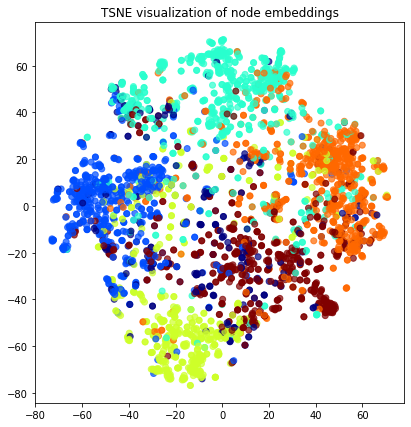

In [16]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Downstream Task

The node representations learned by attri2vec can be used as features for downstream tasks, such as node classification, community detection, and link prediction. As attri2vec inductively learns a mapping function from node content features to the target embeddings, it has the ability to infer the representations for out-of-sample nodes, which can be used to predict the labels or links of out-of-sample nodes.